## Simplest code to implement From scratch in pytorch


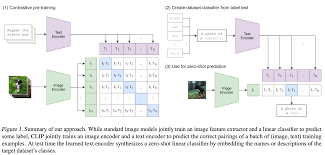

In [ ]:
import torch
import math
from torch import nn
import torch.nn.functional as F

In [ ]:

class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


In [ ]:
class ScaledDotProduct(nn.Module):
  def __init__(self):
    super(ScaledDotProduct, self).__init__()
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, q, k, v, mask, dropout: nn.Dropout):
    d_k = q.shape[-1]
    # Fixed the order of operations
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled.masked_fill_(mask == 0, -1e9)

    attention = self.softmax(scaled)
    if dropout is not None:
        attention = dropout(attention)
    values = torch.matmul(attention, v)
    return values, attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, drop_prob = 0.0, hidden_drop_prob = 0.0):
        super().__init__()
        # Extract parameters from config
        self.d_model = d_model
        assert d_model % n_heads == 0, "d_model must be divisible by h"
        self.d_k = d_model // n_heads
        self.n_heads = n_heads
        bias = True

        # Initialize projection layers
        self.w_q = nn.Linear(self.d_model, self.d_model, bias=bias)
        self.w_k = nn.Linear(self.d_model, self.d_model, bias=bias)
        self.w_v = nn.Linear(self.d_model, self.d_model, bias=bias)
        self.w_o = nn.Linear(self.d_model, self.d_model, bias=bias)

        # Initialize attention mechanism (assumed to be defined elsewhere)
        self.attention = ScaledDotProduct()

        # Initialize dropout layers
        self.attention_dropout = nn.Dropout(drop_prob)
        self.output_dropout = nn.Dropout(hidden_drop_prob)

    def forward(self, x, mask=None,output_attentions=False):
        # Self-attention: q = k = v = x

        q = k = v = x
        #mask = None  # No mask, as per ViT implementation

        # Project inputs
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        # Reshape and transpose for multi-head attention
        query = query.view(query.shape[0], query.shape[1], self.n_heads, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.n_heads, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.n_heads, self.d_k).transpose(1, 2)

        # Compute attention
        x, attention_scores = self.attention(query, key, value, mask, self.attention_dropout)

        # Reshape output
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.n_heads * self.d_k)

        # Apply output projection and dropout
        output = self.w_o(x)
        output = self.output_dropout(output)

        # Return outputs
        # return (output, attention_scores if output_attentions else None)
        if output_attentions:
            return output, attention_scores  # Return both output and attention scores
        else:
            return output, None  # Return None for attention scores

In [ ]:
class PostionalEncoding(nn.Module):
  def __init__(self, d_model, max_seq_length):
    super().__init__()
    self.d_model = d_model
    self.max_seq_length = max_seq_length

    pe = torch.zeros(max_seq_length, d_model)
    position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
    seq_len = x.size(1)
    return x + self.pe[:, :seq_len]


In [ ]:
class NewGELUActivation(nn.Module):
    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))

In [ ]:
class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, d_model, mlp_ratio=4, hidden_drop_prob = 0.0):
        super().__init__()
        self.intermediate_size = mlp_ratio * d_model
        self.dense_1 = nn.Linear(d_model, self.intermediate_size)
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(self.intermediate_size, d_model)
        self.dropout = nn.Dropout(hidden_drop_prob)

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


In [ ]:
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.image_size = img_size
        self.patch_size = patch_size
        self.num_channels = n_channels
        self.hidden_size = d_model
        self.num_patches = (img_size[0] * img_size[1] ) // (patch_size[0] * patch_size[1])
        # Calculate the number of patches from the image size and patch size
        #self.num_patches = (self.image_size // self.patch_size) ** 2
        print(f"Number of patches: {self.num_patches}, Expected tokens with CLS: {self.num_patches + 1}")

        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


In [ ]:

class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, d_model, img_size, patch_size, n_channels, hidden_drop_prob=0.0):
        super().__init__()

        self.patch_embeddings = PatchEmbeddings(d_model, img_size, patch_size, n_channels)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, d_model))
        self.dropout = nn.Dropout(hidden_drop_prob)

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [ ]:

class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, d_model, n_heads):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.layernorm_1 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model)
        self.layernorm_2 = nn.LayerNorm(d_model)

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)

        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # if output_attentions:
        #     return (x, attention_probs)
        # else:
        #     return (x, None)  # Return None for attention scores when not requested
        return x

In [ ]:
class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, d_model, n_heads, n_layers):
        super().__init__()
        # Create a list of transformer blocks
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.blocks = nn.ModuleList([])
        for _ in range(n_layers):
            block = Block(d_model, n_heads)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x = block(x, output_attentions=output_attentions)
            # if output_attentions:
            #     all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        # if not output_attentions:
        #     return (x, None)
        # else:
        #     return (x, all_attentions)
        return x

In [ ]:
class VisionEncoder(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self,d_model,img_size,patch_size, n_channels, n_heads,n_layers, emb_dim):
        super().__init__()

        self.image_size = img_size
        self.emb_dim = emb_dim
        self.hidden_size = d_model
        self.n_channels = n_channels
        self.n_layers = n_layers
        self.patch_size = patch_size
        self.img_size = img_size
        # Create the embedding module
        self.embedding = Embeddings(d_model, img_size, patch_size, n_channels)
        # Create the transformer encoder module
        self.encoder = Encoder(d_model, n_heads, n_layers)
        self.ln_final = nn.LayerNorm(d_model)

        # Create a linear layer to project the encoder's output to the number of classes
        self.projection = nn.Parameter(torch.randn(self.hidden_size, self.emb_dim))
        # Initialize the weights


    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_outputs = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        encoder_output = self.ln_final(encoder_outputs)
        pooled_output = encoder_output[:, 0]

        #logits = encoder_output[:, 0]
        # Return the logits and the attention probabilities (optional)
        if self.projection is not None:
            pooled_output = pooled_output @ self.projection

        # Normalize for contrastive learning
        pooled_output = pooled_output / torch.norm(pooled_output, dim=-1, keepdim=True)

        # if not output_attentions:
        return pooled_output
        # else:
        #     return pooled_output, all_attentions




In [ ]:
def tokenizer(text, encode=True, mask=None, max_seq_length=32):
    if encode:
        # Adding SOT and EOT tokens
        out = chr(2) + text + chr(3)

        # Truncate if length exceeds max_seq_length
        if len(out) > max_seq_length:
            out = out[:max_seq_length]

        # Add padding if needed
        out = out + "".join([chr(0) for _ in range(max_seq_length - len(out))])

        # Encode the text
        out = torch.IntTensor(list(out.encode("utf-8")))

        # Create the mask
        mask = torch.ones(len(out.nonzero()))

        # Pad the mask to max_seq_length
        if len(mask) < max_seq_length:
            mask = torch.cat((mask, torch.zeros(max_seq_length - len(mask)))).type(torch.IntTensor)
        else:
            mask = mask.type(torch.IntTensor)
    else:
        # Decode the text
        out = [chr(x) for x in text[1:len(mask.nonzero()) - 1]]
        out = "".join(out)
        mask = None

    return out, mask

In [ ]:
class TextEncoder(nn.Module):
  def __init__(self, vocab_size, d_model, max_seq_length, n_layers,n_heads, emb_dim):
      super().__init__()

      self.max_seq_length = max_seq_length

      self.embed = nn.Embedding(vocab_size, d_model)

      self.positional_embedding = PostionalEncoding(d_model, max_seq_length)

      self.transformer_encoder = nn.ModuleList([Block(d_model, n_heads) for _ in range(n_layers)])

      self.projection = nn.Parameter(torch.randn(d_model, emb_dim))

   # For training
  def forward(self, text, mask = None):

      x = self.embed(text)

      x = self.positional_embedding(x)

      for encoder_layer in self.transformer_encoder:
          x = encoder_layer(x)

      #The output of the encoder layers is the text features. We are going to be using the features from the EOT embedding.

      x = x[torch.arange(text.shape[0]), torch.sub(torch.sum(mask[:,0],dim=1),1)]

      if self.projection is not None:
         x = x @ self.projection

      x = x / torch.norm(x, dim=-1, keepdim = True)

      return x

In [ ]:
class TextEncoder_Retrieval(nn.Module):
  def __init__(self, vocab_size, d_model, max_seq_length, n_layers,n_heads, emb_dim):
      super().__init__()

      self.max_seq_length = max_seq_length

      self.embed = nn.Embedding(vocab_size, d_model)

      self.positional_embedding = PostionalEncoding(d_model, max_seq_length)

      self.transformer_encoder = nn.ModuleList([Block(d_model, n_heads) for _ in range(n_layers)])

      self.projection = nn.Parameter(torch.randn(d_model, emb_dim))


 # # For image retrieval
  def forward(self, text, mask=None):
        x = self.embed(text)
        x = self.positional_embedding(x)

        for encoder_layer in self.transformer_encoder:
            x = encoder_layer(x)

        if mask is not None:
            # Get the lengths of each sequence (i.e., find the last non-padded token)
            seq_lengths = mask.sum(dim=1) - 1  # Subtract 1 to get the index
            x = x[torch.arange(text.shape[0]), seq_lengths]
        else:
            x = x[:, -1]  # If no mask is provided, take the last token in the sequence.

        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)

        return x

In [ ]:
class CLIP(nn.Module):

    def __init__(self, emb_dim, vit_layers, vit_d_model, img_size, patch_size, n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers, text_d_model, retrieval = False):
        super().__init__()

        self.vision_encoder = VisionEncoder(vit_d_model, img_size, patch_size, n_channels, vit_heads, vit_layers, emb_dim) #Vision Encoder

        self.text_encoder = TextEncoder(vocab_size, text_d_model, max_seq_length, text_layers, text_heads, emb_dim) #Text Encoder

        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def CLIPLoss(self, logits, device = "cuda"):
        #Symmetric or Contrastive loss
    # arange generates a list between 0 and n-1
        labels = torch.arange(logits.shape[0]).to(device)  # For row 1 we want 1,1 to be max, and row n-1 we want (n-1,n-1) text pairs to be max --> time 15.43 umar

        loss_v = nn.functional.cross_entropy(logits.transpose(-2,-1), labels)

        loss_t = nn.functional.cross_entropy(logits, labels)
        loss = (loss_v + loss_t) / 2

        return loss

    def forward(self, image, text, mask=None):
      V_e = self.vision_encoder(image)  # Extract just the embeddings
      T_e = self.text_encoder(text, mask)  # Extract just the embeddings

      logits = (V_e @ T_e.transpose(-2, -1)) * torch.exp(self.temperature)

      loss = self.CLIPLoss(logits, self.device)

      return loss


In [ ]:
Remb_dim = 128
vit_d_model = 32 # vit_heads * vit_layers = vit_d_model
img_size = (80,80)
patch_size = (5,5)
n_channels = 3
vit_layers = 8
vit_heads = 4

# Text
vocab_size = 256
text_d_model = 64 #  -->  text_heads * text_layers = text_d_model
max_seq_length = 128
text_heads = 8
text_layers = 8
lr = 1e-3
epochs = 50
batch_size = 128

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageOps
import pdb
import os
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')



In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small -q

In [ ]:
!unzip fashion-product-images-small.zip -d fashion

In [ ]:
# Load the dataset
df = pd.read_csv('fashion/myntradataset/styles.csv', usecols=['id',  'subCategory'])

unique, counts = np.unique(df["subCategory"].tolist(), return_counts = True)
print(f"Classes: {unique}: {counts}")

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.10, random_state=42)

# Print the sizes of the datasets
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")
class_names = df['subCategory'].unique()
class_names = [str(name).lower() for name in class_names]

# Replace in-place
for i, name in enumerate(class_names):
    if name == "lips":
        class_names[i] = "lipstick"
    elif name == "eyes":
        class_names[i] = "eyelash"
    elif name == "nails":
        class_names[i] = "nail polish"

captions = {idx: class_name for idx, class_name in enumerate(class_names)}

for idx, caption in captions.items():
    print(f"{idx}: {caption}\n")

Classes: ['Accessories' 'Apparel Set' 'Bags' 'Bath and Body' 'Beauty Accessories'
 'Belts' 'Bottomwear' 'Cufflinks' 'Dress' 'Eyes' 'Eyewear' 'Flip Flops'
 'Fragrance' 'Free Gifts' 'Gloves' 'Hair' 'Headwear' 'Home Furnishing'
 'Innerwear' 'Jewellery' 'Lips' 'Loungewear and Nightwear' 'Makeup'
 'Mufflers' 'Nails' 'Perfumes' 'Sandal' 'Saree' 'Scarves'
 'Shoe Accessories' 'Shoes' 'Skin' 'Skin Care' 'Socks'
 'Sports Accessories' 'Sports Equipment' 'Stoles' 'Ties' 'Topwear'
 'Umbrellas' 'Vouchers' 'Wallets' 'Watches' 'Water Bottle' 'Wristbands']: [  143   106  3055    12     4   811  2694   108   478    43  1073   915
  1012   104    20    19   293     1  1808  1080   527   470   307    38
   329     6   963   427   118    24  7344    69    77   698     3    21
    90   258 15405     6     1   933  2542     7     4]
Train size: 40001, Validation size: 4445
0: topwear

1: bottomwear

2: watches

3: socks

4: shoes

5: belts

6: flip flops

7: bags

8: innerwear

9: sandal

10: shoe accessorie

In [ ]:
class MyntraDataset(Dataset):
    def __init__(self, data_frame, captions, target_size=28):

        self.data_frame = data_frame[data_frame['subCategory'].str.lower() != 'innerwear']
        self.target_size = target_size  # Desired size for the square image
        self.transform = T.Compose([
            T.ToTensor()  # Convert image to tensor
        ])

        self.captions = captions

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        while True:
            sample = self.data_frame.iloc[idx]
            img_path = os.path.join("fashion/myntradataset/images", f"{sample['id']}.jpg")

            try:
                # Attempt to open the image
                image = Image.open(img_path).convert('RGB')
            except (FileNotFoundError, IOError):
                # If the image is not found, skip this sample by incrementing the index
                idx = (idx + 1) % len(self.data_frame)  # Loop back to the start if we reach the end
                continue  # Retry with the next index

            # Resize the image to maintain aspect ratio
            image = self.resize_and_pad(image, self.target_size)

            # Apply transformations (convert to tensor)
            image = self.transform(image)

            # Retrieve the subCategory label and its corresponding caption
            label = sample['subCategory'].lower()
            label = {"lips": "lipstick", "eyes": "eyelash", "nails": "nail polish"}.get(label, label)

            label_idx = next(idx for idx, class_name in self.captions.items() if class_name == label)

            # # Tokenize the caption using the tokenizer function
            cap, mask = tokenizer(self.captions[label_idx])

            # Make sure the mask is a tensor
            mask = torch.tensor(mask)

            # If the mask is a single dimension, make sure it is expanded correctly
            if len(mask.size()) == 1:
                mask = mask.unsqueeze(0)

            return {"image": image, "caption": cap, "mask": mask,"id": img_path}

    def resize_and_pad(self, image, target_size):
        original_width, original_height = image.size
        aspect_ratio = original_width / original_height

        if aspect_ratio > 1:
            new_width = target_size
            new_height = int(target_size / aspect_ratio)
        else:
            new_height = target_size
            new_width = int(target_size * aspect_ratio)

        image = image.resize((new_width, new_height))

        pad_width = (target_size - new_width) // 2
        pad_height = (target_size - new_height) // 2

        padding = (pad_width, pad_height, target_size - new_width - pad_width, target_size - new_height - pad_height)
        image = ImageOps.expand(image, padding, fill=(0, 0, 0))

        return image

#Create datasets
train_dataset = MyntraDataset(data_frame=train_df ,captions = captions, target_size =80)
val_dataset = MyntraDataset(data_frame=val_df ,captions = captions ,target_size =80)
test_dataset = MyntraDataset(data_frame=val_df, captions = captions, target_size = 224)


print("Number of Samples in Train Dataset:", len(train_dataset))
print("Number of Samples in Validation Dataset:", len(val_dataset))


train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size,num_workers = 5)
val_loader  = DataLoader(val_dataset, shuffle = False, batch_size = batch_size,num_workers = 5)
test_loader = DataLoader(test_dataset, shuffle = False, batch_size = batch_size, num_workers = 5)

#Sanity check of dataloader initialization
len(next(iter(train_loader)))  #(img_tensor,label_tensor)


Number of Samples in Train Dataset: 38360
Number of Samples in Validation Dataset: 4278


4

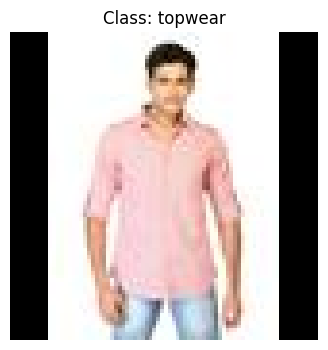

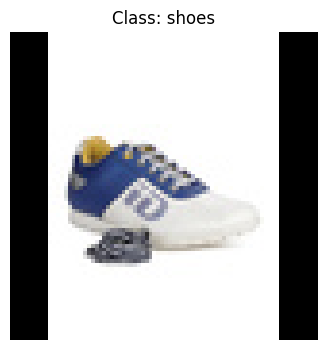

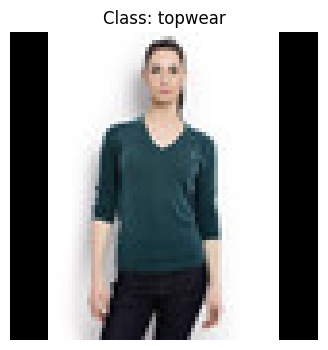

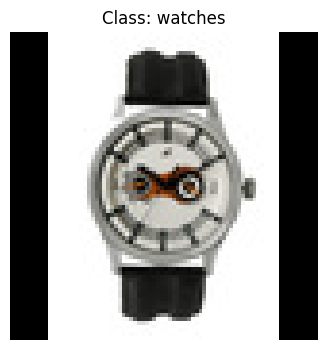

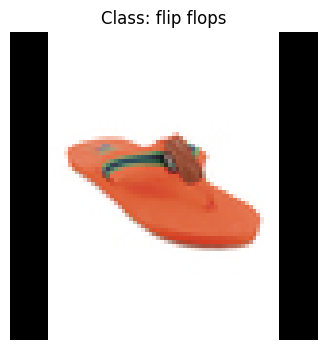

In [ ]:
# Function to visualize a batch of images with their class names
def visualize_samples(dataset, tokenizer, num_samples=5):
    # Get a batch of samples
    for i in range(num_samples):
        sample = dataset[i]  # Access the ith sample in the dataset
        image = sample['image']
        tokenized_caption = sample['caption']
        mask = sample['mask'][0]

        # Decode the tokenized caption to get the original class name
        original_caption = tokenizer(tokenized_caption, encode=False, mask=mask)[0]

        # Convert the tensor image back to a PIL image for visualization
        image = T.ToPILImage()(image)

        # Display the image
        plt.figure(figsize=(4, 4))
        plt.imshow(image,cmap="gray")
        plt.title(f"Class: {original_caption}")  # Display the non-tokenized class name as title
        plt.axis('off')
        plt.show()

# Visualize samples from the train dataset
visualize_samples(train_dataset, tokenizer, num_samples=5)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")


model = CLIP(emb_dim, vit_layers, vit_d_model, img_size,patch_size,n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers,text_d_model, retrieval = False).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)

Using device:  cuda (Tesla T4)
Number of patches: 256, Expected tokens with CLS: 257


In [ ]:
total_params = 0

total_params = sum([ param.numel() for param in model.parameters() if param.requires_grad])

print(f"Total number of trainable parameters: {total_params}; i.e., {total_params/1000000:.2f} M")

Total number of trainable parameters: 540929; i.e., 0.54 M


In [ ]:
best_loss = np.inf
for epoch in range(epochs):
    epoch_loss = 0.0  # To accumulate the loss over the epoch
    with tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch [{epoch+1}/{epochs}]") as tepoch:
        for i, data in tepoch:
            img, cap, mask = data["image"].to(device), data["caption"].to(device), data["mask"].to(device)
            optimizer.zero_grad()
            loss = model(img, cap, mask)
            loss.backward()
            optimizer.step()

            # Update the progress bar with the current loss
            tepoch.set_postfix(loss=loss.item())
            epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.3f}")

    # Save model if it performed better than the previous best
    if avg_loss <= best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "clip.pt")
        print("Model Saved.")

Epoch [1/50]: 100%|██████████| 300/300 [01:08<00:00,  4.38it/s, loss=3.56]

Epoch [1/50], Average Loss: 4.496
Model Saved.



Epoch [2/50]: 100%|██████████| 300/300 [01:05<00:00,  4.55it/s, loss=2.83]

Epoch [2/50], Average Loss: 3.577
Model Saved.



Epoch [3/50]: 100%|██████████| 300/300 [01:06<00:00,  4.53it/s, loss=2.9]

Epoch [3/50], Average Loss: 3.212
Model Saved.



Epoch [4/50]: 100%|██████████| 300/300 [01:06<00:00,  4.53it/s, loss=2.86]

Epoch [4/50], Average Loss: 3.111
Model Saved.



Epoch [5/50]: 100%|██████████| 300/300 [01:06<00:00,  4.54it/s, loss=3.01]

Epoch [5/50], Average Loss: 3.057
Model Saved.



Epoch [6/50]: 100%|██████████| 300/300 [01:06<00:00,  4.52it/s, loss=2.75]

Epoch [6/50], Average Loss: 3.015
Model Saved.



Epoch [7/50]: 100%|██████████| 300/300 [01:06<00:00,  4.52it/s, loss=2.79]

Epoch [7/50], Average Loss: 2.983
Model Saved.



Epoch [8/50]: 100%|██████████| 300/300 [01:06<00:00,  4.53it/s, loss=2.46]

Epoch [8/50], Average Loss: 2.956
Model Saved.



Epoch [9/50]: 100%|██████████| 300/300 [01:06<00:00,  4.50it/s, loss=2.64]

Epoch [9/50], Average Loss: 2.930
Model Saved.



Epoch [10/50]: 100%|██████████| 300/300 [01:06<00:00,  4.53it/s, loss=2.61]

Epoch [10/50], Average Loss: 2.914
Model Saved.



Epoch [11/50]: 100%|██████████| 300/300 [01:06<00:00,  4.53it/s, loss=2.76]

Epoch [11/50], Average Loss: 2.901
Model Saved.



Epoch [12/50]: 100%|██████████| 300/300 [01:06<00:00,  4.52it/s, loss=2.7]

Epoch [12/50], Average Loss: 2.884
Model Saved.



Epoch [13/50]: 100%|██████████| 300/300 [01:06<00:00,  4.53it/s, loss=2.67]

Epoch [13/50], Average Loss: 2.867
Model Saved.



Epoch [14/50]: 100%|██████████| 300/300 [01:06<00:00,  4.54it/s, loss=2.49]

Epoch [14/50], Average Loss: 2.858
Model Saved.



Epoch [15/50]: 100%|██████████| 300/300 [01:06<00:00,  4.54it/s, loss=2.79]

Epoch [15/50], Average Loss: 2.853
Model Saved.



Epoch [16/50]: 100%|██████████| 300/300 [01:06<00:00,  4.50it/s, loss=2.54]

Epoch [16/50], Average Loss: 2.838
Model Saved.



Epoch [17/50]: 100%|██████████| 300/300 [01:05<00:00,  4.55it/s, loss=2.4]

Epoch [17/50], Average Loss: 2.831
Model Saved.



Epoch [18/50]: 100%|██████████| 300/300 [01:05<00:00,  4.56it/s, loss=2.83]

Epoch [18/50], Average Loss: 2.817
Model Saved.



Epoch [19/50]: 100%|██████████| 300/300 [01:06<00:00,  4.54it/s, loss=2.44]

Epoch [19/50], Average Loss: 2.809
Model Saved.



Epoch [20/50]:  27%|██▋       | 82/300 [00:18<00:50,  4.35it/s, loss=2.86]


KeyboardInterrupt: 

In [ ]:
model = CLIP(emb_dim, vit_layers, vit_d_model, img_size,patch_size,n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers,text_d_model,retrieval = False).to(device)

model.load_state_dict(torch.load("clip.pt", map_location=device))

text = torch.stack([tokenizer(x)[0] for x in val_dataset.captions.values()]).to(device)

mask = torch.stack([tokenizer(x)[1] for x in val_dataset.captions.values()])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

correct, total = 0,0
with torch.no_grad():
    for data in val_loader:

        images, labels = data["image"].to(device), data["caption"].to(device)
        image_features = model.vision_encoder(images)
        text_features = model.text_encoder(text, mask=mask)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        _, indices = torch.max(similarity,1)

        pred = torch.stack([tokenizer(val_dataset.captions[int(i)])[0] for i in indices]).to(device)
        correct += int(sum(torch.sum((pred==labels),dim=1)//len(pred[0])))

        total += len(labels)

print(f'\nModel Accuracy: {100 * correct // total} %')

Number of patches: 256, Expected tokens with CLS: 257

Model Accuracy: 81 %


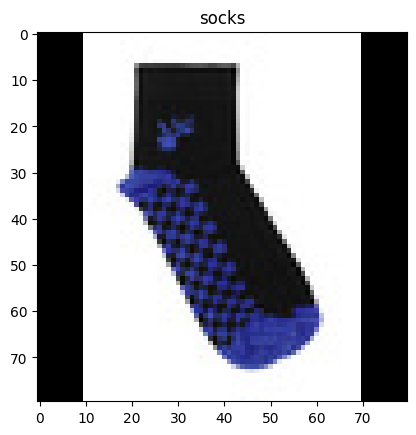


Top predictions:

           socks: 100.00%
          gloves: 0.00%
        mufflers: 0.00%
          stoles: 0.00%
loungewear and nightwear: 0.00%


In [ ]:
dx = 904


img = val_dataset[idx]["image"][None,:]
plt.imshow(img[0].permute(1, 2, 0)  ,cmap="gray")
plt.title(tokenizer(val_dataset[idx]["caption"], encode=False, mask=val_dataset[idx]["mask"][0])[0])
plt.show()
img = img.to(device)
with torch.no_grad():
  image_features = model.vision_encoder(img)
  text_features = model.text_encoder(text, mask=mask)


image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{class_names[int(index)]:>16s}: {100 * value.item():.2f}%")